In [1]:
import colorsys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.ticker as plticker
import mal_cfr_data.plot as mcd_plt
import mal_cfr_data.tournament as mcd_tournament

mcd_plt.set_plt_params(font_size=20)
div_color_palette = mcd_plt.diverging_color_palette()
seq_color_palette = mcd_plt.sequential_color_palette()

date = 'feb10_2021'

In [2]:
data = mcd_tournament.Data.load()
data.data

game_tag sampler  seed   mode row_alg         col_alg   value    t
0            sheriff    null  None    sim     CFR             CFR   0.375    0
1            sheriff    null  None    sim     CFR       CFR_EX+IN   0.375    0
2            sheriff    null  None    sim     CFR          CFR_IN   0.375    0
3            sheriff    null  None    sim     CFR        A-CFR_IN   0.375    0
4            sheriff    null  None    sim     CFR         BPS-CFR   0.375    0
...              ...     ...   ...    ...     ...             ...     ...  ...
1138495  tiny_hanabi    null  None  fixed      BR        CSPS-CFR  10.000  499
1138496  tiny_hanabi    null  None  fixed      BR        CFPS-CFR  10.000  499
1138497  tiny_hanabi    null  None  fixed      BR  CFPS-CFR_EX+IN   8.000  499
1138498  tiny_hanabi    null  None  fixed      BR  TIPS-CFR_EX+IN   8.000  499
1138499  tiny_hanabi    null  None  fixed      BR       BEHAV-CFR  10.000  499

[1138500 rows x 8 columns]

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


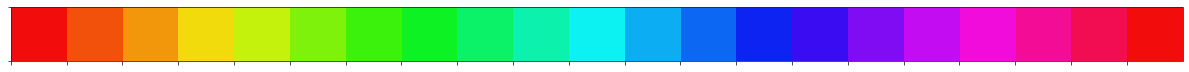

In [3]:
color_palettes = [colorsys.hls_to_rgb(f, 0.5, 0.9) for f in np.arange(0, 1.05, 0.05)]
print(np.arange(0, 1.05, 0.05))
sns.palplot(color_palettes)

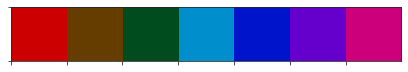

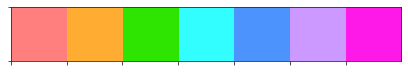

In [4]:
dark_hues = [0, 0.1, 0.4, 0.55, 0.65, 0.75, 0.9]
dark_lightness = [0.4, 0.2, 0.15, 0.4, 0.4, 0.4, 0.4]
light_hues = [1, 0.1, 0.3, 0.5, 0.6, 0.75, 0.85]
light_lightness = [0.75, 0.6, 0.45, 0.6, 0.65, 0.8, 0.55]
dark_colors = [colorsys.hls_to_rgb(h, dark_lightness[i], 1) for i, h in enumerate(dark_hues)]
sns.palplot(dark_colors)
light_colors = [colorsys.hls_to_rgb(h, light_lightness[i], 1) for i, h in enumerate(light_hues)]
sns.palplot(light_colors)

In [5]:
# Setting algorithm comparison groups
hsr_alg_comparisons = (('CFR', 'A-CFR_IN', 'CFR_IN', 'CFR_EX+IN'),)
rla_alg_comparisons = (
    ('CFR', 'A-CFR_IN', 'CFR_IN', 'CFR_EX+IN'),  # Weak algorithms
    ("BPS-CFR", "CFPS-CFR", "CSPS-CFR", 'TIPS-CFR', 'BEHAV-CFR'),  # PS algorithms
    ("CFPS-CFR", 'TIPS-CFR', "CFPS-CFR_EX+IN", 'TIPS-CFR_EX+IN'),  # PS alternatives
)
mike_alg_comparisons = (
    ('CFR', 'BPS-CFR', 'TIPS-CFR'),
)
nf_algs = ('CFR', 'CFR_IN', 'CFR_EX+IN')
alg_comparisons = rla_alg_comparisons
all_algs = set()
for alg_group in alg_comparisons:
    all_algs = all_algs.union({alg for alg in alg_group})
print(all_algs)

# Setup algorithm specific colors
cf_color_idx = 3
act_color_idx = 6
l1_ps_color_idx = 0
l2_ps_color_idx = 4
alg_color = {
    'CFR': dark_colors[cf_color_idx],
    'A-CFR_IN': dark_colors[act_color_idx],
    'CFR_IN': light_colors[cf_color_idx],
    "BPS-CFR": dark_colors[l1_ps_color_idx],
    "CFPS-CFR": light_colors[l1_ps_color_idx],
    "CSPS-CFR": dark_colors[l2_ps_color_idx],
    'TIPS-CFR': light_colors[l2_ps_color_idx],
    'BEHAV-CFR': (0, 0, 0),
    'CFR_EX+IN': dark_colors[2],
    "CFPS-CFR_EX+IN": dark_colors[1],
    'TIPS-CFR_EX+IN': dark_colors[5],
}
            
learning_curve_query_string = 'game_tag == "{game}" & mode == "{mode}"\
    & col_alg == {col_algs}\
    & row_alg == {algs}'

# Exclude algorithms not in any comparison group
data.data = data.data.query(f'col_alg == {list(all_algs)} & row_alg == {list(all_algs)}')


{'A-CFR_IN', 'BEHAV-CFR', 'CFR', 'CFPS-CFR_EX+IN', 'CFR_EX+IN', 'TIPS-CFR', 'CFPS-CFR', 'TIPS-CFR_EX+IN', 'CSPS-CFR', 'CFR_IN', 'BPS-CFR'}


In [6]:
def sharex_and_y_in_row(axes_list):
    shared_x = axes_list[0].get_shared_x_axes()
    shared_y = axes_list[0].get_shared_y_axes()
    for ax in axes_list[1:]:
        shared_x.join(axes_list[0], ax)
        shared_y.join(axes_list[0], ax)
        
def sharex_in_row(axes_list):
    for j, ax in enumerate(axes_list[1:]):
        axes_list[j - 1].sharex(ax)

def learning_curve_data(df, cumsum=True):
    df = df.pivot(index=['col_alg', 'row_alg'], columns='t', values='value')
    normalizer = 1.0
    if (cumsum):
        df = df.cumsum(axis=1)
        normalizer += df.columns.to_numpy()
    return (df.mean(level=1) / normalizer).T.sort_index(axis=1, key=mcd_tournament.alg_sort_keys)

def goofspiel_score_to_win_percentage(df):
    return (df + 1.) / 2.0 * 100

def is_goofspiel(game_tag):
    return game_tag[:len('goofspiel')] == 'goofspiel' or game_tag == 'random_goofspiel'

def is_leduc(game_tag):
    return game_tag == 'leduc'

def leduc_score_to_milli_antes(df):
    return df * 1000

avg_learning_curve_ylabel = r'avg.\ payoff'
inst_learning_curve_ylabel = 'payoff'

def leduc_learning_curve_config(df, ax, j, avg=True):
    if j == 0:
        ax.set_ylabel(
            fr'{avg_learning_curve_ylabel if avg else inst_learning_curve_ylabel} (mbb)')
    return leduc_score_to_milli_antes(df)

def goofspiel_learning_curve_config(df, ax, j, avg=True):
    if j == 0:
        ax.set_ylabel(r'avg.\ win \%' if avg else r'win \%')
    return goofspiel_score_to_win_percentage(df)

def learning_curve_figsize(games, alg_comparisons):
    return (5 + 1)/1.2 * len(alg_comparisons), 3.5/1.2 * len(games)

def learning_curves_adjust_spacing():
    plt.tight_layout(pad=0.1)
    plt.subplots_adjust(wspace=0.25, hspace=0.4)

def learning_curves_subplots(games, alg_comparisons):
    return plt.subplots(
        len(games),
        len(alg_comparisons),
        squeeze=False,
        figsize=learning_curve_figsize(games, alg_comparisons),
    #     gridspec_kw={'width_ratios': [0.25, 1, 1]}
    )

def learning_curves_legend(ax, ncol=2):
    ax.legend(
        ncol=ncol,
        fontsize='x-small',
        columnspacing=0.5,
        labelspacing=0.25,
        handletextpad=0.4,
        handlelength=0.5)

def learning_curves_set_ticks(ax):
    loc = plticker.MultipleLocator(base=100)
    ax.xaxis.set_major_locator(loc)
    start, end = ax.get_ylim()
    loc = plticker.MultipleLocator(base=(end - start) / 4.0)
    ax.yaxis.set_major_locator(loc)


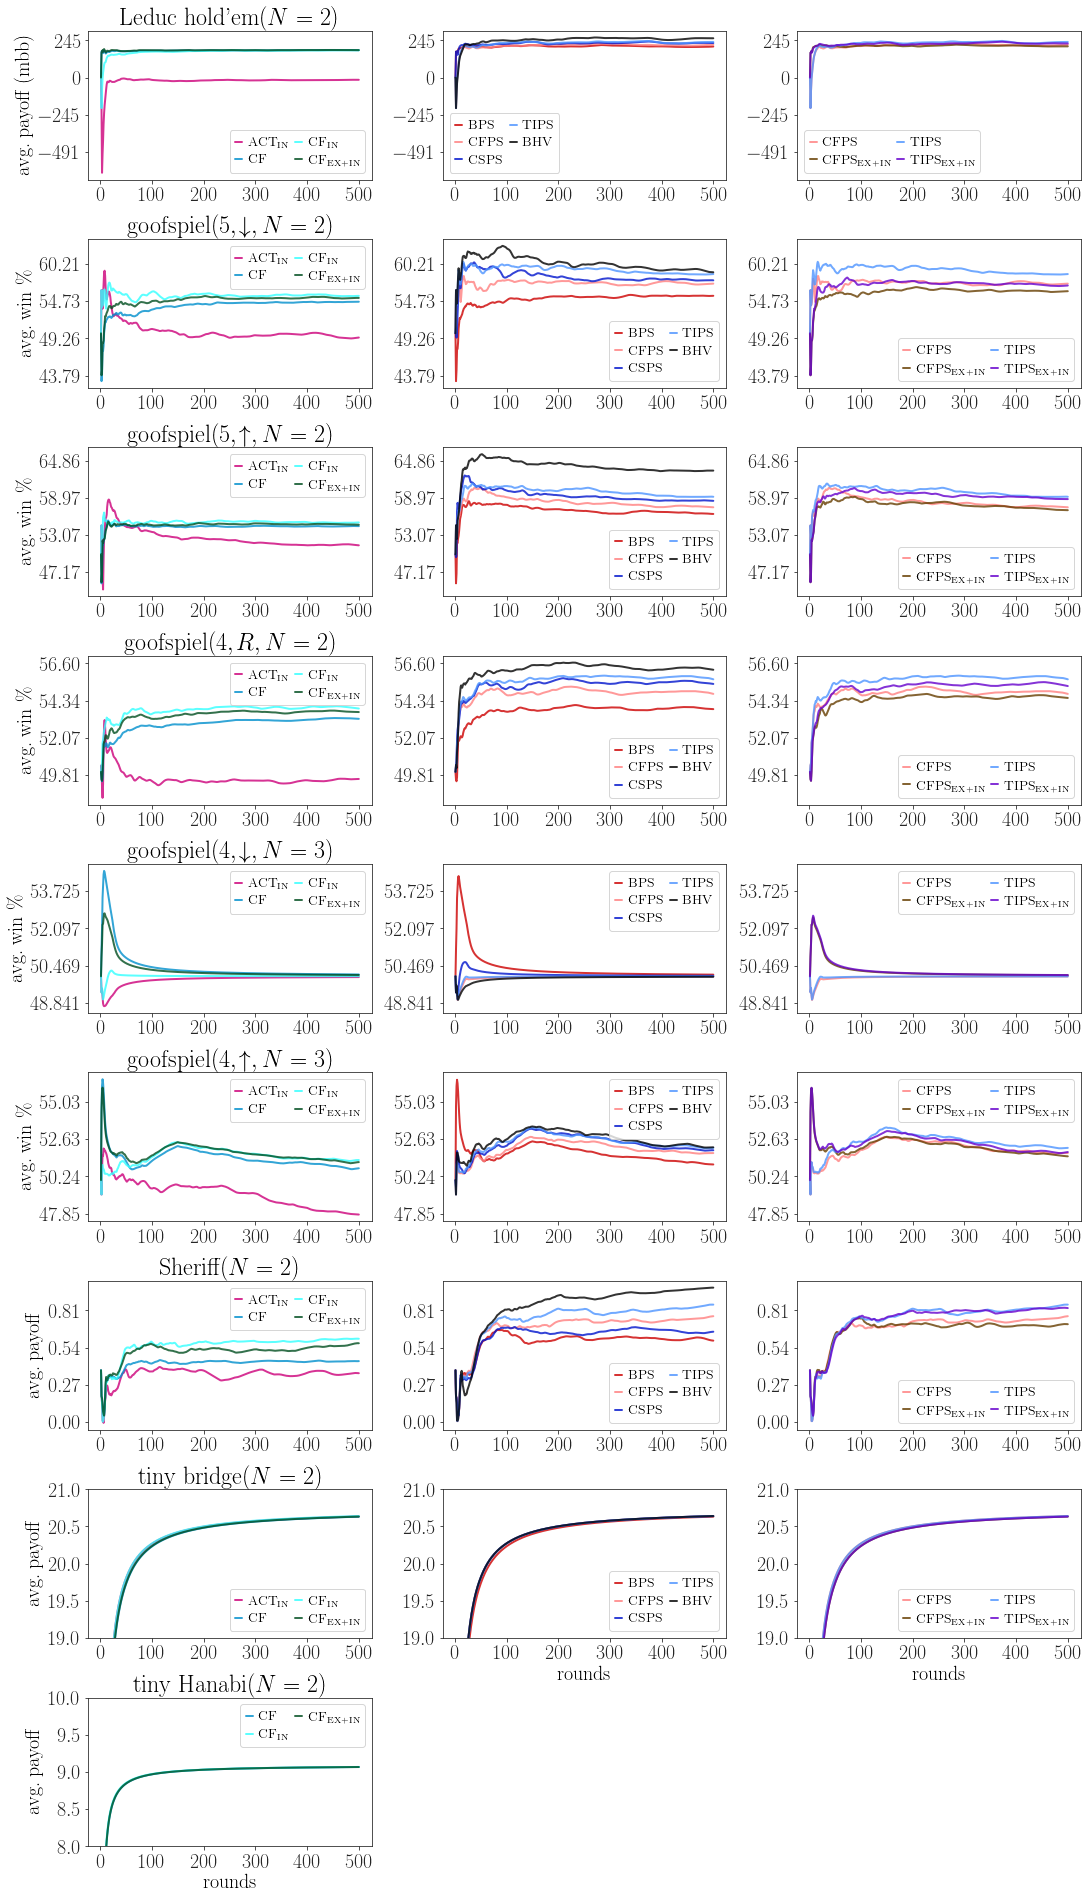

In [7]:
ylim_by_game = {
    'tiny_bridge': (19, 21),
    'tiny_hanabi': (8, 10),
}
games = data.games()
fig, axes_list = learning_curves_subplots(games, alg_comparisons)
for i, game_tag in enumerate(sorted(games, key=mcd_tournament.game_sort_key)):
    sharex_and_y_in_row(axes_list[i, :])
    if game_tag == 'tiny_hanabi':
        _alg_comparisons = [nf_algs]
        axes_list[i, 0].set_xlabel('rounds')
        for ax in axes_list[i, 1:]:
            ax.set_axis_off()
    else:
        _alg_comparisons = alg_comparisons
    for j, alg_group in enumerate(_alg_comparisons):
        ax = axes_list[i, j]
        _df = learning_curve_data(
            data.data.query(
                learning_curve_query_string.format(
                    game=game_tag,
                    mode='fixed',
                    algs=alg_group,
                    col_algs=list(all_algs))))
        if is_leduc(game_tag):
            _df = leduc_learning_curve_config(_df, ax, j)
        elif is_goofspiel(game_tag):
            _df = goofspiel_learning_curve_config(_df, ax, j)
        elif j == 0:
            ax.set_ylabel(avg_learning_curve_ylabel)
        for alg in _df.columns:
            ax.plot(
                _df.index.to_numpy() + 1.0,
                _df[alg],
                lw=2,
                alpha=0.8,
                label=mcd_tournament.alg_label(alg),
                color=alg_color[alg]
            )
        if game_tag in ylim_by_game:
            ax.set_ylim(ylim_by_game[game_tag])
        learning_curves_legend(ax)
    axes_list[i, 0].set_title(mcd_tournament.game_label(game_tag))
    for ax in axes_list[i, :]:
        learning_curves_set_ticks(ax)
for ax in axes_list[-2, 1:]:
    ax.set_xlabel('rounds')
learning_curves_adjust_spacing()
plt.savefig(f'results/learning_curves.fixed.{date}.pdf')

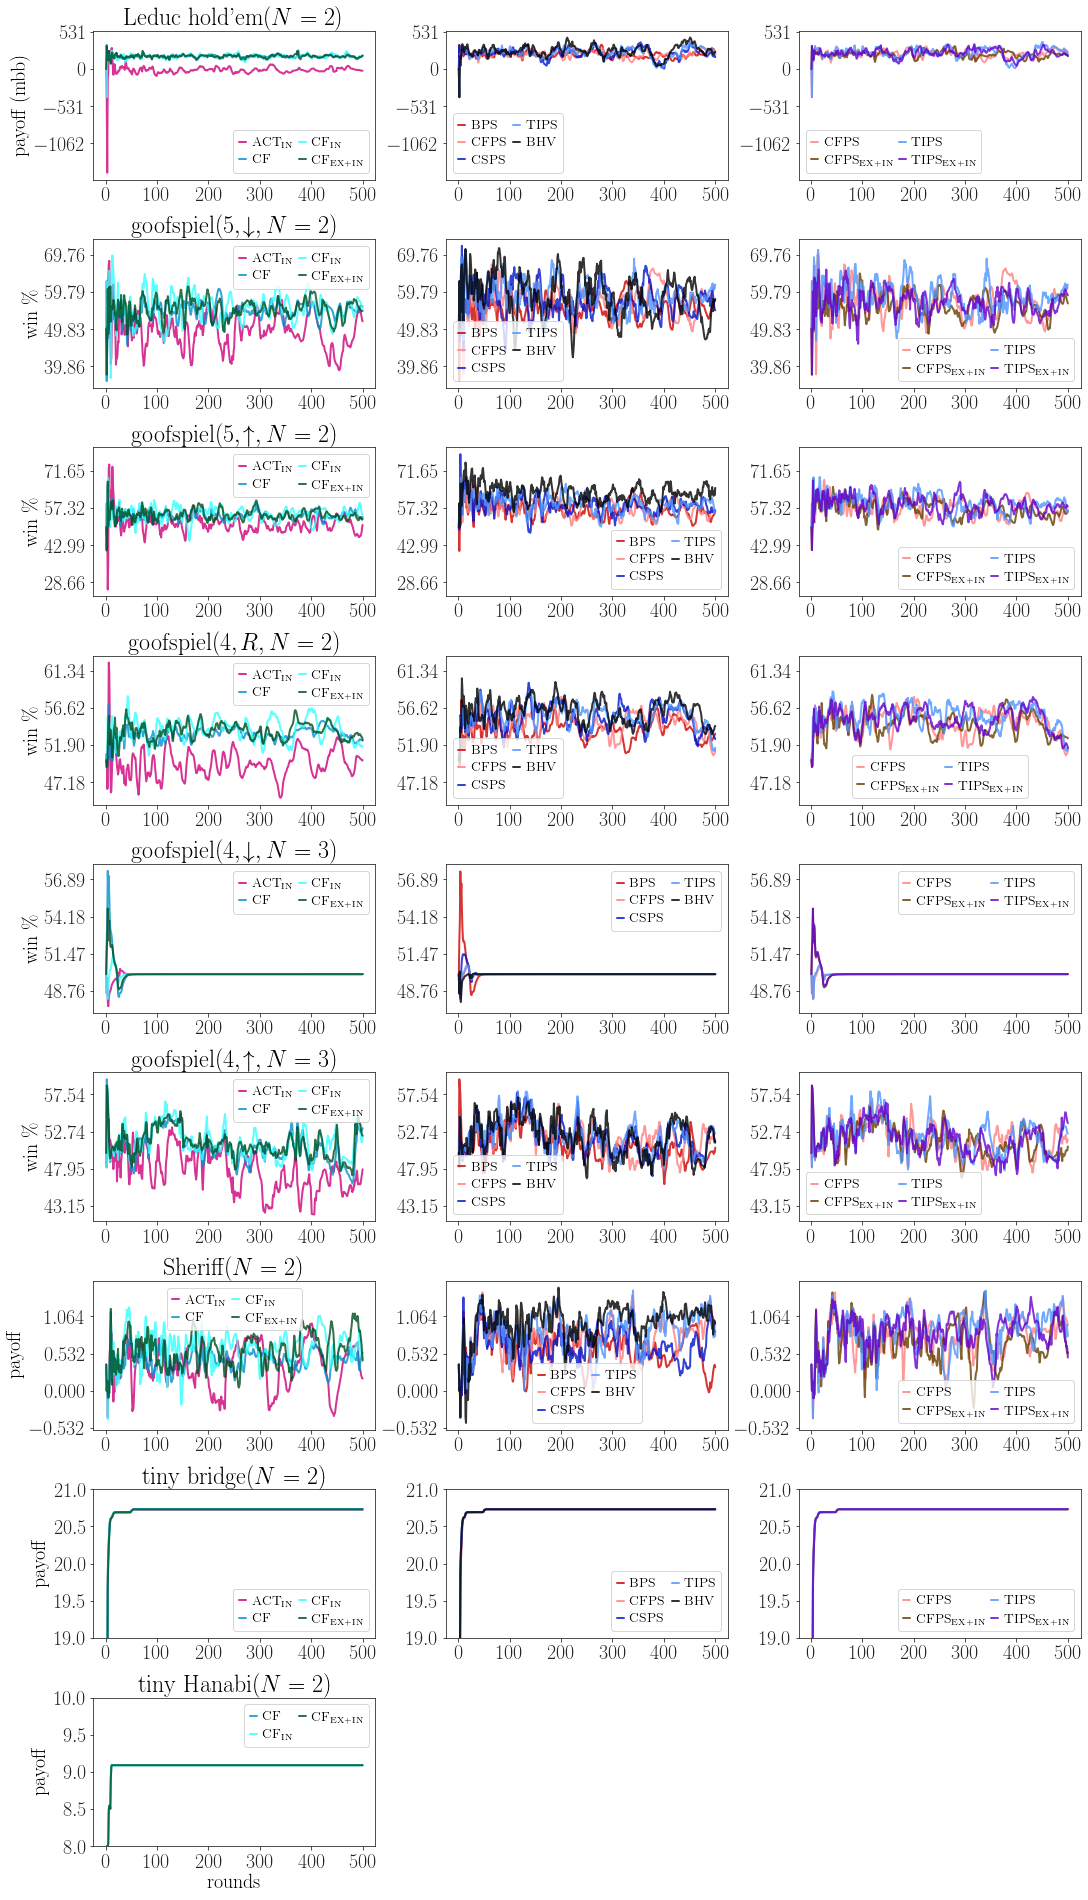

In [8]:
# ylim_by_game = {
# }

games = data.games()
fig, axes_list = learning_curves_subplots(games, alg_comparisons)
for i, game_tag in enumerate(sorted(games, key=mcd_tournament.game_sort_key)):
    sharex_and_y_in_row(axes_list[i, :])
    if game_tag == 'tiny_hanabi':
        _alg_comparisons = [nf_algs]
        axes_list[i, 0].set_xlabel('rounds')
        for ax in axes_list[i, 1:]:
            ax.set_axis_off()
    else:
        _alg_comparisons = alg_comparisons
    for j, alg_group in enumerate(_alg_comparisons):
        ax = axes_list[i, j]
        _df = learning_curve_data(
            data.data.query(
                learning_curve_query_string.format(
                    game=game_tag,
                    mode='fixed',
                    algs=alg_group,
                    col_algs=list(all_algs))),
            False)
        if is_leduc(game_tag):
            _df = leduc_learning_curve_config(_df, ax, j, avg=False)
        elif is_goofspiel(game_tag):
            _df = goofspiel_learning_curve_config(_df, ax, j, avg=False)
        elif j == 0:
            ax.set_ylabel(inst_learning_curve_ylabel)
        for alg in _df.columns:
            ax.plot(
                _df.index.to_numpy() + 1.0,
                _df[alg],
                lw=2,
                alpha=0.8,
                label=mcd_tournament.alg_label(alg),
                color=alg_color[alg]
            )
        if game_tag in ylim_by_game:
            ax.set_ylim(ylim_by_game[game_tag])
        learning_curves_legend(ax)
    axes_list[i, 0].set_title(mcd_tournament.game_label(game_tag))
    for ax in axes_list[i, :]:
        learning_curves_set_ticks(ax)
for ax in axes_list[-1, :]:
    ax.set_xlabel('rounds')
learning_curves_adjust_spacing()
plt.savefig(f'results/learning_curves.fixed.inst.{date}.pdf')

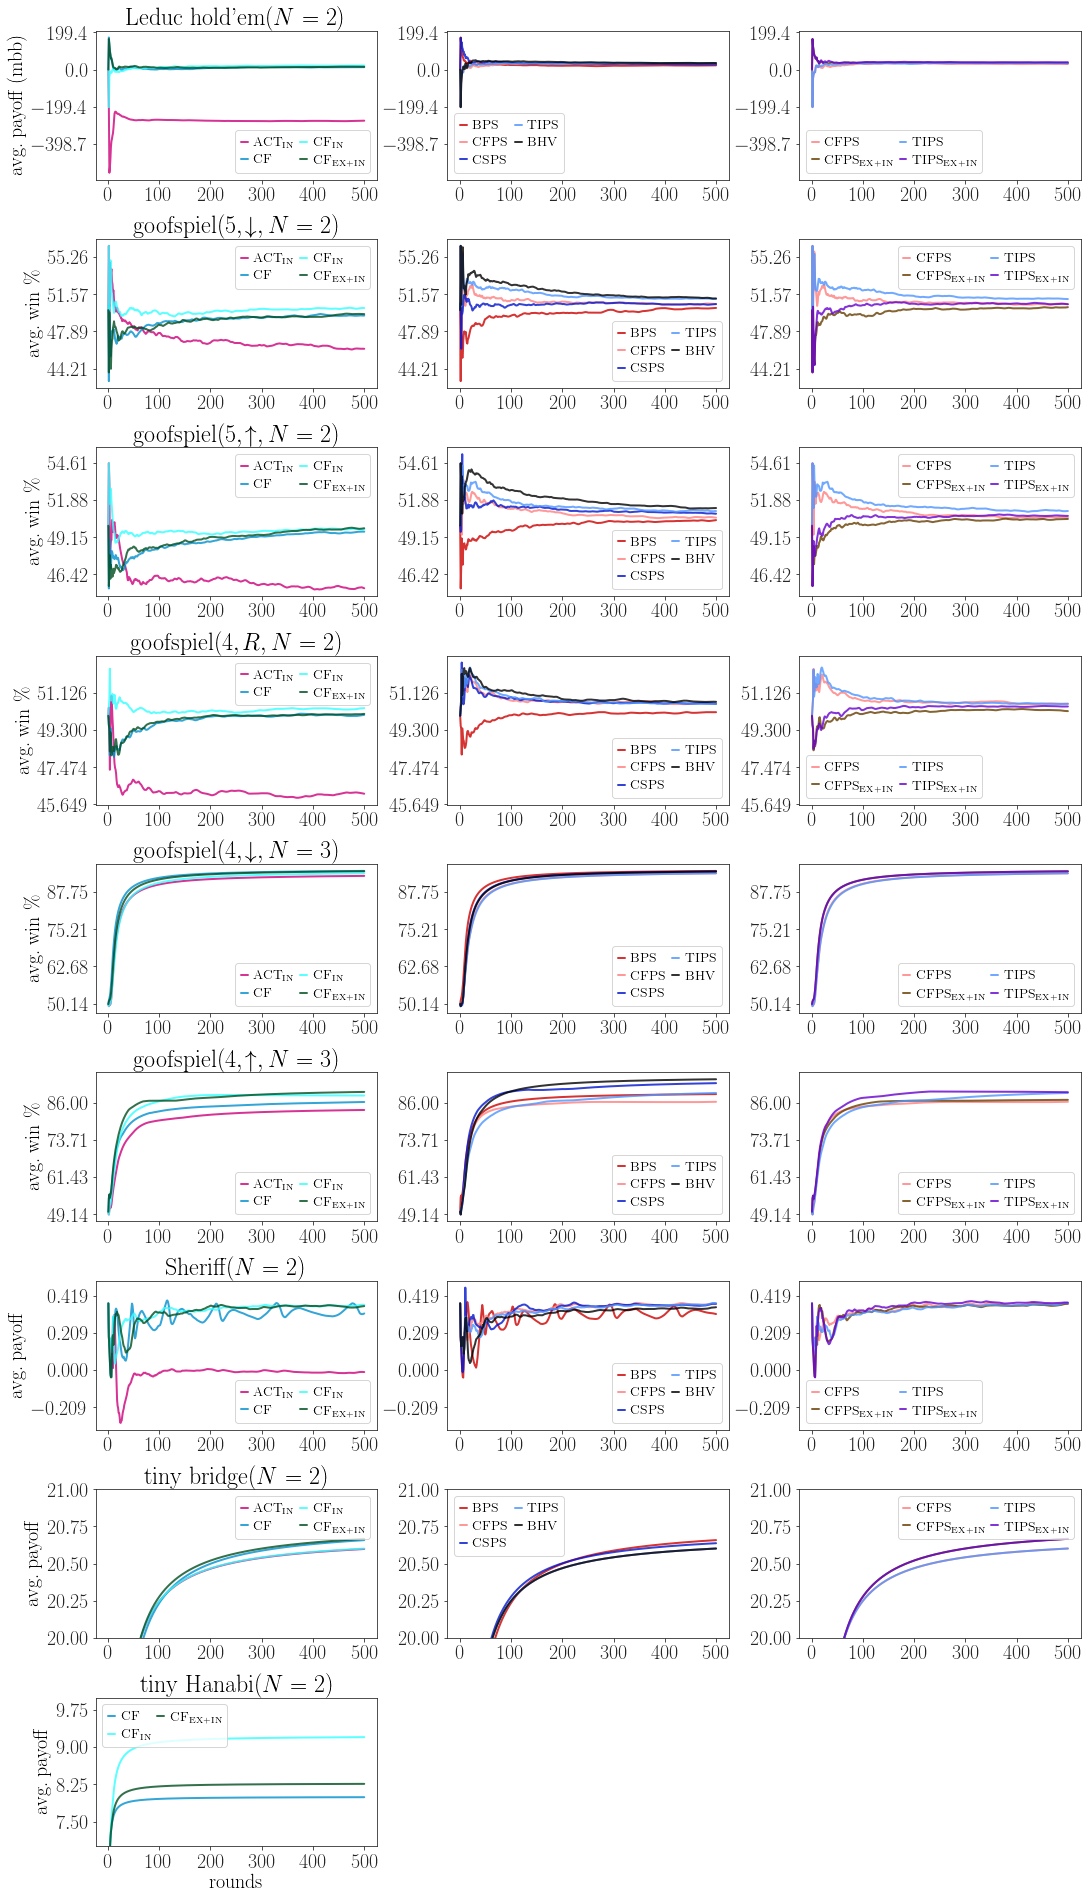

In [9]:
ylim_by_game = {
    'tiny_bridge': (20, 21),
    'tiny_hanabi': (7, 10),
}

games = data.games()
fig, axes_list = learning_curves_subplots(games, alg_comparisons)
for i, game_tag in enumerate(sorted(games, key=mcd_tournament.game_sort_key)):
    sharex_and_y_in_row(axes_list[i, :])
    if game_tag == 'tiny_hanabi':
        _alg_comparisons = [nf_algs]
        axes_list[i, 0].set_xlabel('rounds')
        for ax in axes_list[i, 1:]:
            ax.set_axis_off()
    else:
        _alg_comparisons = alg_comparisons
    for j, alg_group in enumerate(_alg_comparisons):
        ax = axes_list[i, j]
        _df = learning_curve_data(
            data.data.query(
                learning_curve_query_string.format(
                    game=game_tag,
                    mode='sim',
                    algs=alg_group,
                    col_algs=list(all_algs))))
        if is_leduc(game_tag):
            _df = leduc_learning_curve_config(_df, ax, j)
        elif is_goofspiel(game_tag):
            _df = goofspiel_learning_curve_config(_df, ax, j)
        elif j == 0:
            ax.set_ylabel(avg_learning_curve_ylabel)
        for alg in _df.columns:
            ax.plot(
                _df.index.to_numpy() + 1.0,
                _df[alg],
                lw=2,
                alpha=0.8,
                label=mcd_tournament.alg_label(alg),
                color=alg_color[alg]
            )
        if game_tag in ylim_by_game:
            ax.set_ylim(ylim_by_game[game_tag])
        learning_curves_legend(ax)
    axes_list[i, 0].set_title(mcd_tournament.game_label(game_tag))
    for ax in axes_list[i, :]:
        learning_curves_set_ticks(ax)
for ax in axes_list[-1, :]:
    ax.set_xlabel('rounds')
learning_curves_adjust_spacing()
plt.savefig(f'results/learning_curves.sim.{date}.pdf')

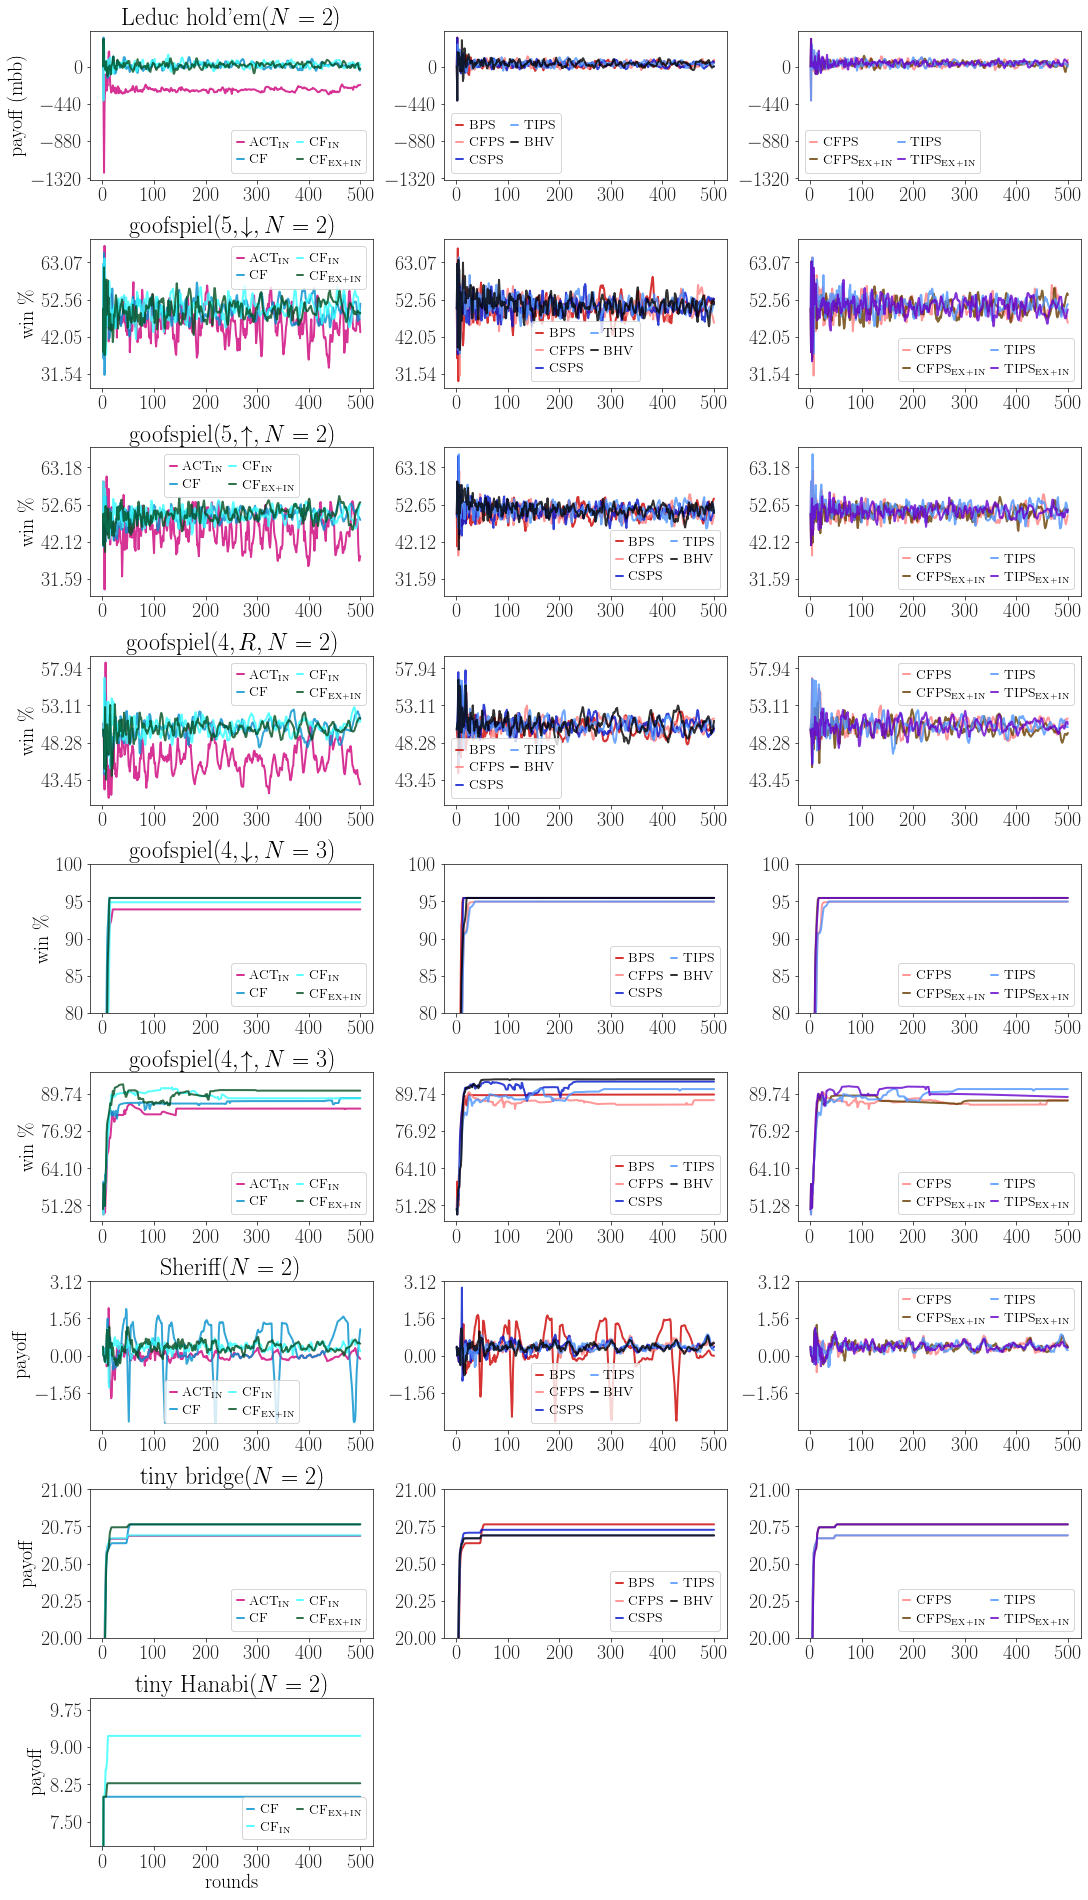

In [10]:
ylim_by_game = {
    'goofspiel_3p': (80, 100),
    'tiny_bridge': (20, 21),
    'tiny_hanabi': (7, 10),
}

games = data.games()
fig, axes_list = learning_curves_subplots(games, alg_comparisons)
for i, game_tag in enumerate(sorted(games, key=mcd_tournament.game_sort_key)):
    sharex_and_y_in_row(axes_list[i, :])
    if game_tag == 'tiny_hanabi':
        _alg_comparisons = [nf_algs]
        axes_list[i, 0].set_xlabel('rounds')
        for ax in axes_list[i, 1:]:
            ax.set_axis_off()
    else:
        _alg_comparisons = alg_comparisons
    for j, alg_group in enumerate(_alg_comparisons):
        ax = axes_list[i, j]
        _df = learning_curve_data(
            data.data.query(
                learning_curve_query_string.format(
                    game=game_tag,
                    mode='sim',
                    algs=alg_group,
                    col_algs=list(all_algs))),
            False)
        if is_leduc(game_tag):
            _df = leduc_learning_curve_config(_df, ax, j, avg=False)
        elif is_goofspiel(game_tag):
            _df = goofspiel_learning_curve_config(_df, ax, j, avg=False)
        elif j == 0:
            ax.set_ylabel(inst_learning_curve_ylabel)
        for alg in _df.columns:
            ax.plot(
                _df.index.to_numpy() + 1.0,
                _df[alg],
                lw=2,
                alpha=0.8,
                label=mcd_tournament.alg_label(alg),
                color=alg_color[alg]
            )
        if game_tag in ylim_by_game:
            ax.set_ylim(ylim_by_game[game_tag])
        learning_curves_legend(ax)
    axes_list[i, 0].set_title(mcd_tournament.game_label(game_tag))
    for ax in axes_list[i, :]:
        learning_curves_set_ticks(ax)
for ax in axes_list[-1, :]:
    ax.set_xlabel('rounds')
learning_curves_adjust_spacing()
plt.savefig(f'results/learning_curves.sim.inst.{date}.pdf')

In [11]:
# plt.figure(figsize=(10, 3))
# mcd_tournament.heatmap(
#     mcd_tournament.without_br_row(data.fixed_table('kuhn_3p')),
#     cmap=div_color_palette
# )

In [12]:
# for seed in data.all_seeds():
#     if not np.isnan(seed):
#         plt.figure(figsize=(10, 3))
#         mcd_tournament.heatmap(
#             mcd_tournament.without_br_row(
#                 data.shuffled_table('kuhn_3p', seed)) * 1000,
#             cmap=div_color_palette)
#         plt.show()

In [13]:
# (data.shuffled_table_by_seed("kuhn_3p") * 1000).std().max()

In [14]:
# (data.max_abs_diff_from_mean("kuhn_3p") * 1000).max()

In [15]:
# _df = data.time_avg_sim_table('tiny_hanabi', 200).query('row_alg == ["CFR", "FP"] & col_alg == ["CFR"]')

leduc
goofspiel
goofspiel_ascending
random_goofspiel
goofspiel_3p
goofspiel_ascending_3p
sheriff
tiny_bridge
tiny_hanabi


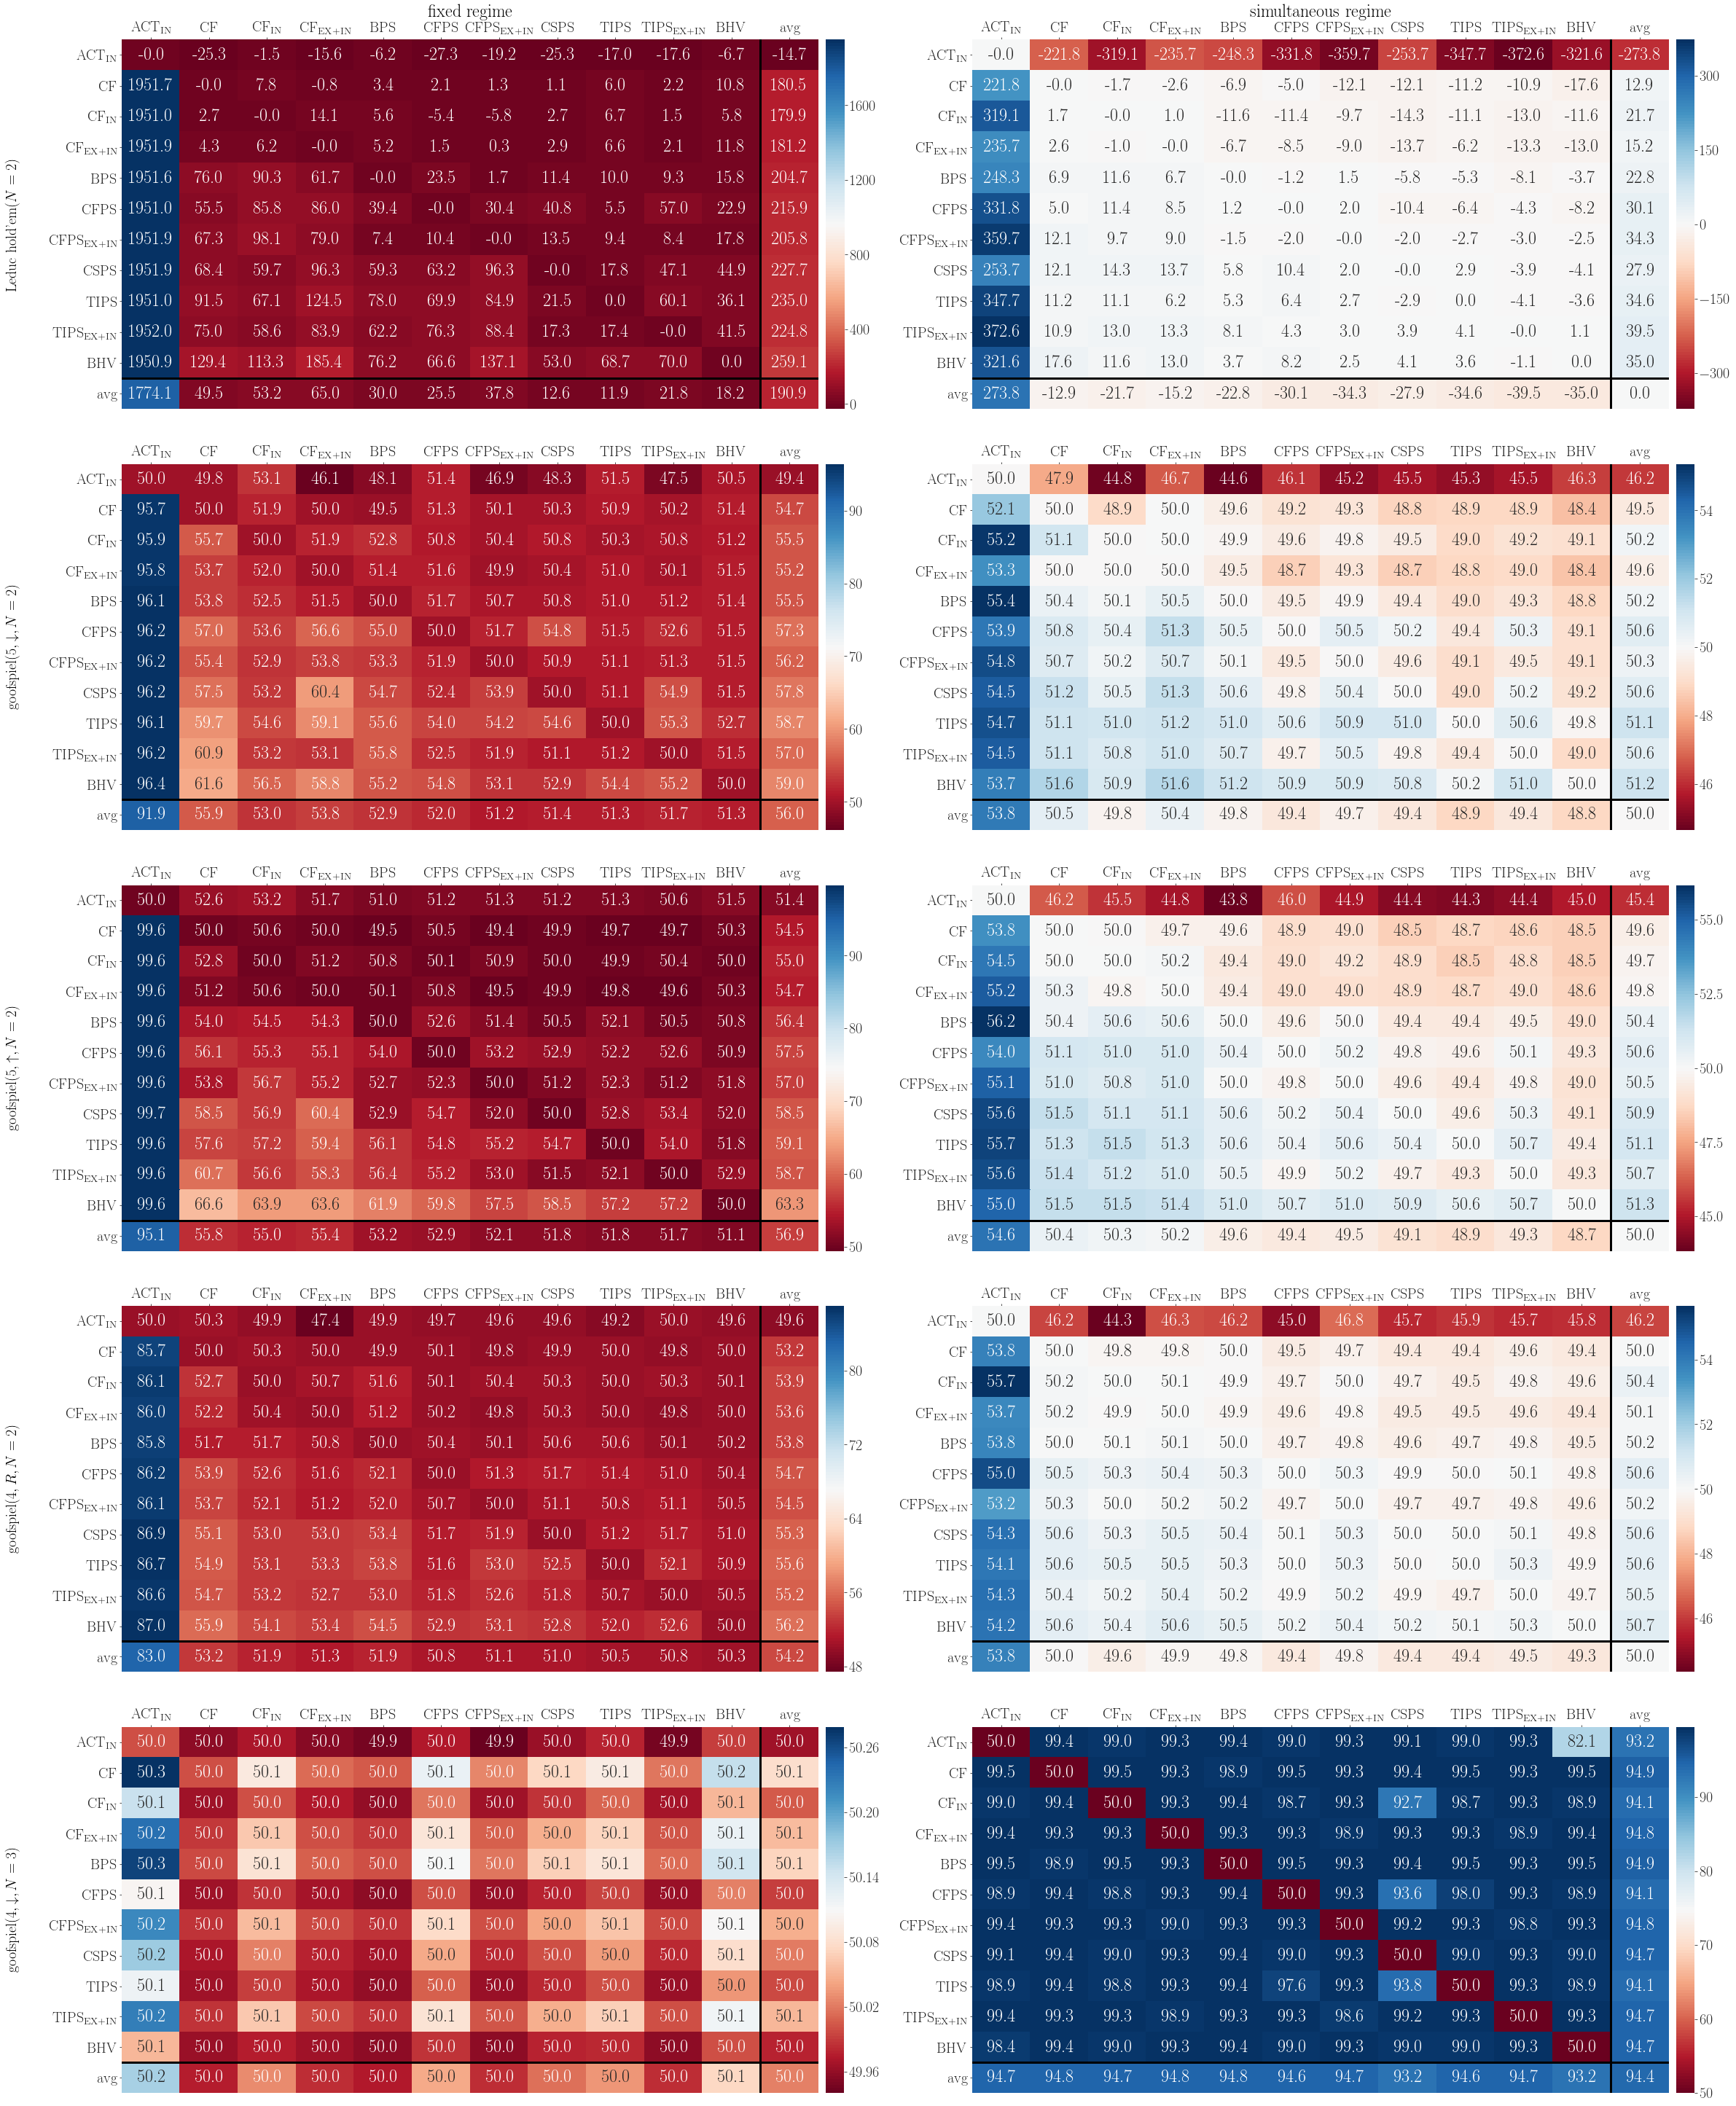

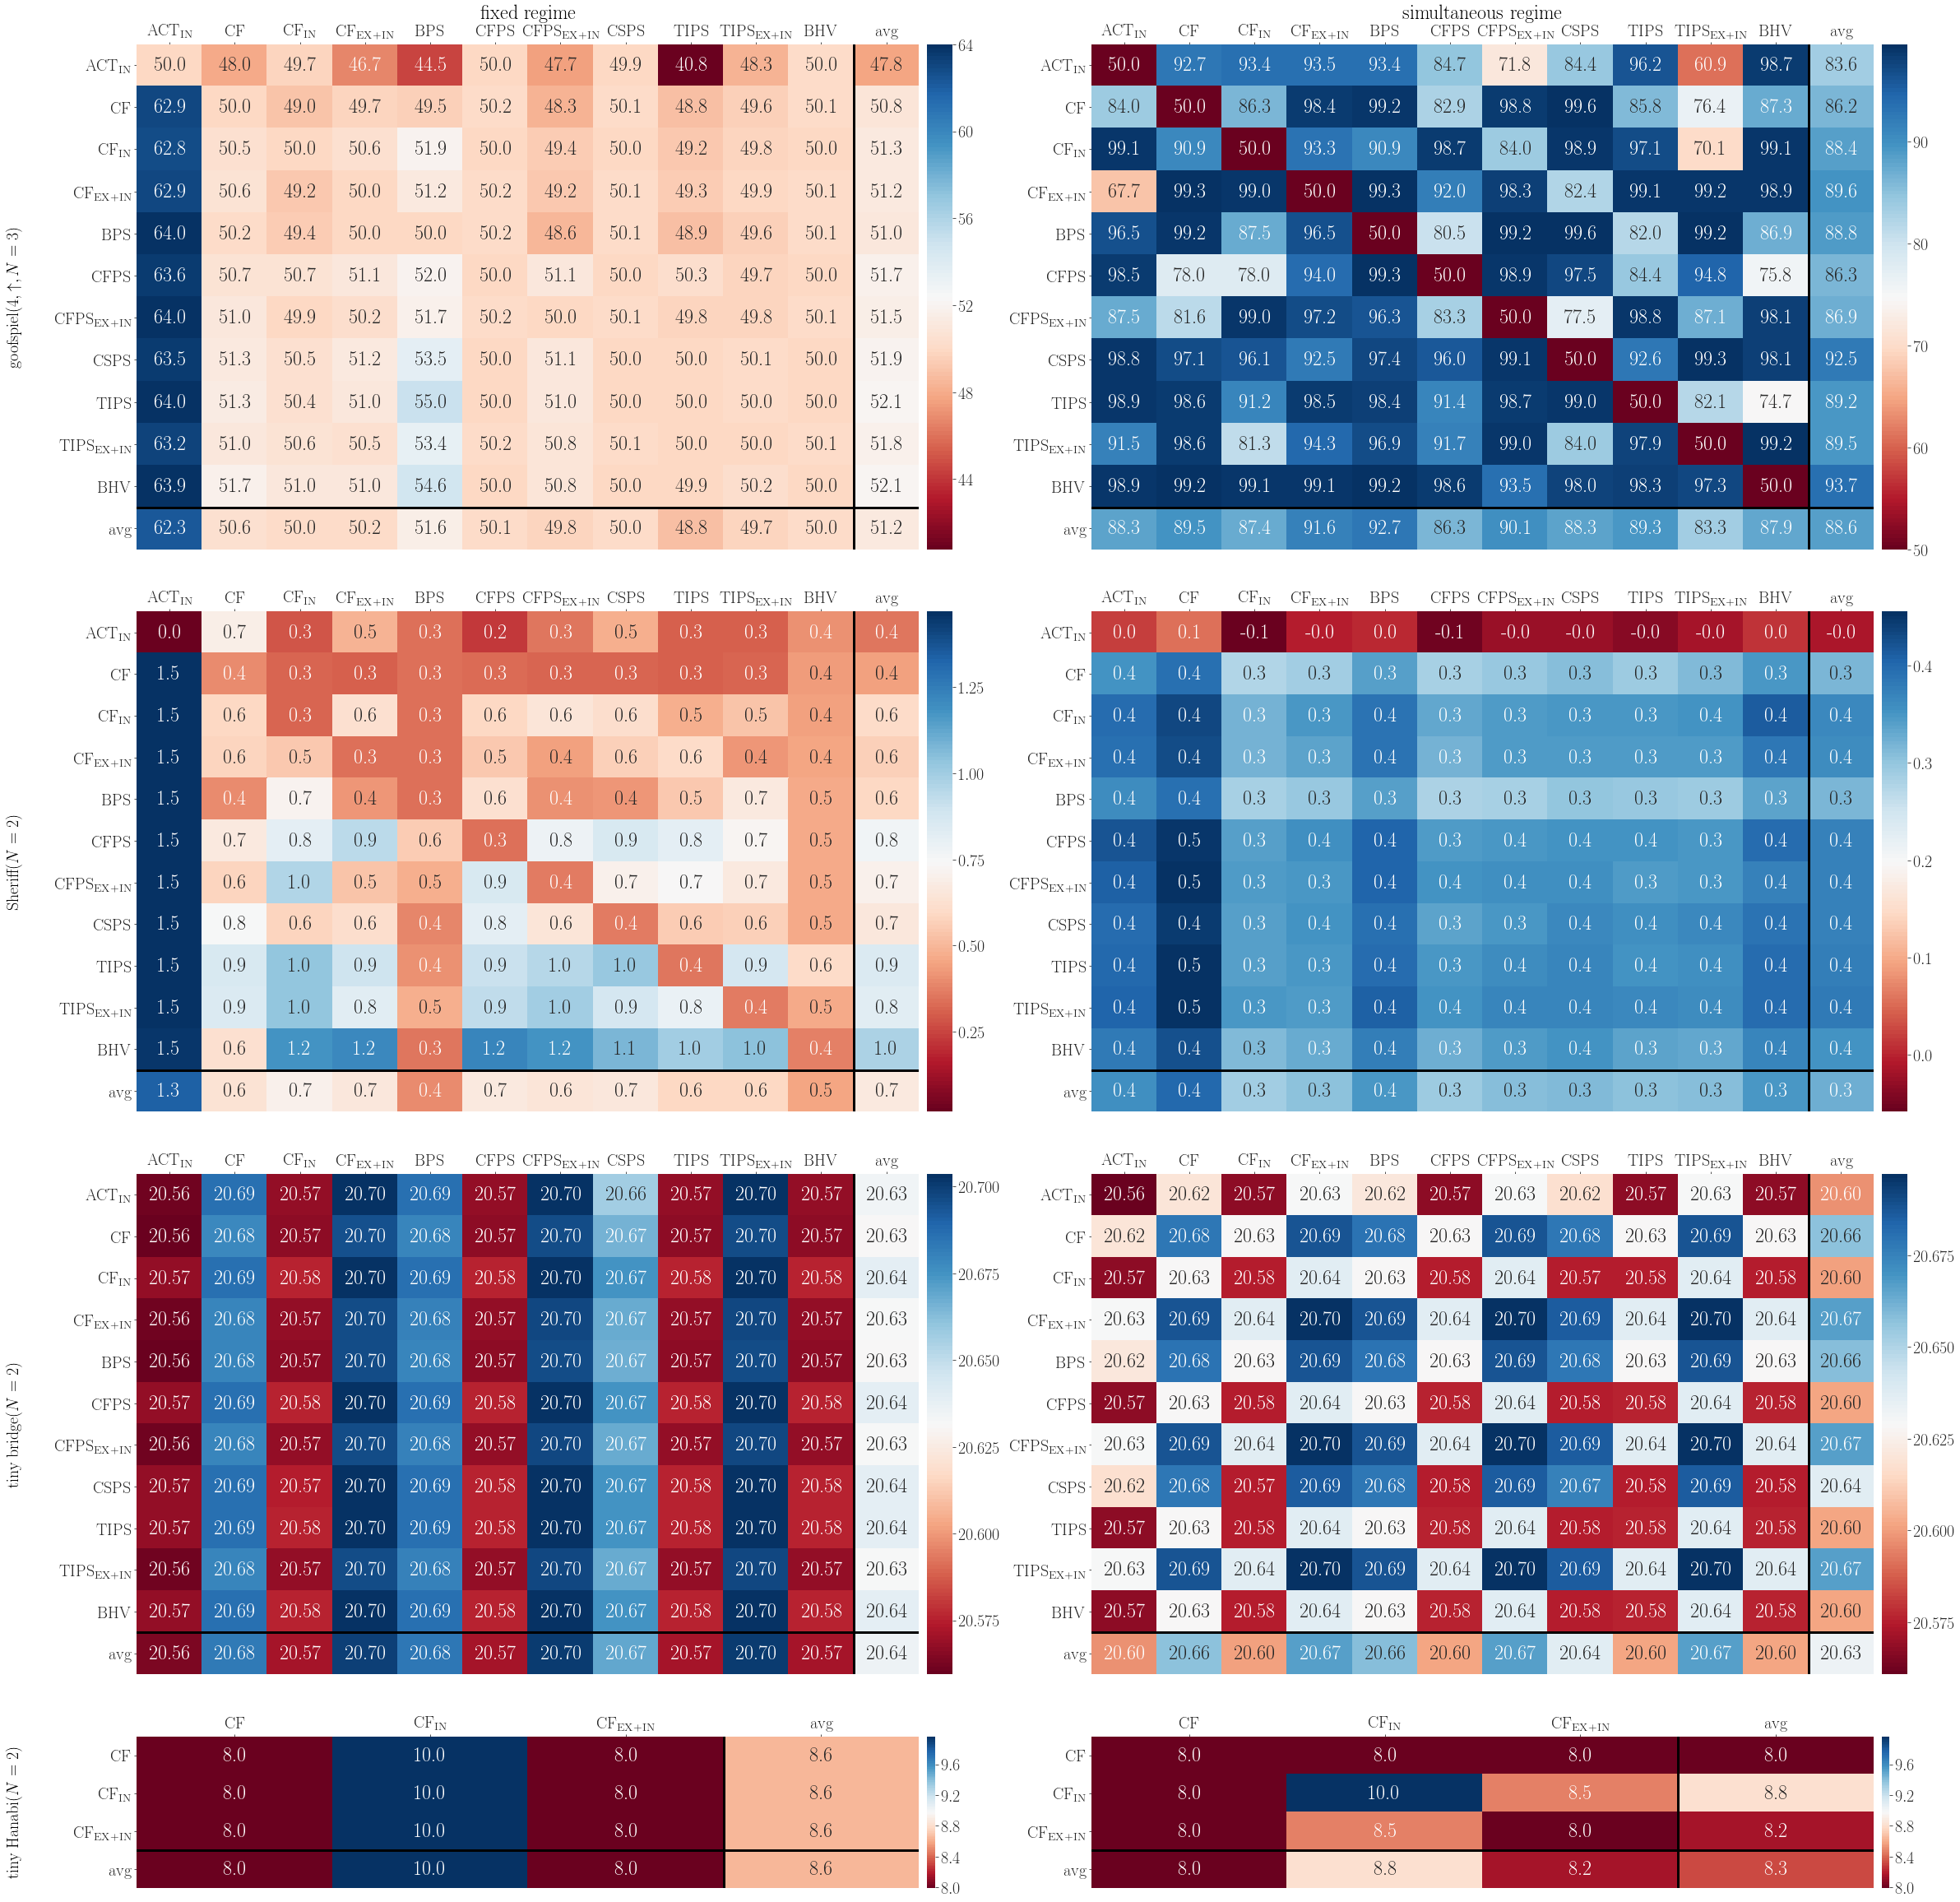

In [31]:
# mcd_plt.set_plt_params(font_size=24)

num_rounds = 501
num_cols = 2
games = data.games()
num_games1 = len(games)
num_games1 = int(np.ceil(num_games1 / 2))
fig, axes_list = plt.subplots(
    num_games1,
    num_cols + 1,
    squeeze=False,
    figsize=(33, 8 * num_games1),
    gridspec_kw={'width_ratios': [0.01, 1, 1], 'height_ratios': [1] + [0.99] * (num_games1 - 1)})
axes_list[0, 1].set_title('fixed regime')
axes_list[0, 2].set_title('simultaneous regime')

num_games2 = int(np.floor(len(games) / 2))
fig2, axes_list2 = plt.subplots(
    num_games2,
    num_cols + 1,
    squeeze=False,
    figsize=(33, 8 * num_games2),
    gridspec_kw={'width_ratios': [0.01, 1, 1], 'height_ratios': [1] + [0.99]*(num_games2 - 2) + [0.3]})
axes_list2[0, 1].set_title('fixed regime')
axes_list2[0, 2].set_title('simultaneous regime')

axes_list = np.concatenate([axes_list, axes_list2], axis=0)
for i, game in enumerate(games):
    print(game)
    axes_list[i, 2].sharex(axes_list[i, 1])
    axes_list[i, 2].sharey(axes_list[i, 1])
#     axes_list[i, 2].yaxis.set_visible(False)

    if game == 'tiny_hanabi':
        _df = data.data.query(
            ' & '.join([
                f'game_tag == "{game}"',
                'mode == "fixed"',
                f't < {num_rounds}',
                f'row_alg == {list(nf_algs)}',
                f'col_alg == {list(nf_algs)}',
            ]))
        _df = _df.pivot(index='t', columns=['row_alg', 'col_alg'],
                        values='value').mean().unstack()
    else:
        _df = mcd_tournament.without_br_row(data.time_avg_fixed_table(game, num_rounds))
        
    fmt = "0.1f"
    if is_leduc(game):
        _df = leduc_score_to_milli_antes(_df)
    elif is_goofspiel(game):
        _df = goofspiel_score_to_win_percentage(_df)
        fmt = "0.1f"
    elif game == 'tiny_bridge':
        fmt = "0.2f"
    
    mcd_tournament.heatmap(
        _df,
        fmt=fmt,
        ax=axes_list[i, 1],
        cmap=div_color_palette,
        cbar_kws={'fraction': 0.05, 'pad': 0.01})
    
    if game == 'tiny_hanabi':
        _df = data.data.query(
            ' & '.join([
                f'game_tag == "{game}"',
                'mode == "sim"',
                f't < {num_rounds}',
                f'row_alg == {list(nf_algs)}',
                f'col_alg == {list(nf_algs)}',
            ]))
        _df = _df.pivot(index='t', columns=['row_alg', 'col_alg'],
                        values='value').mean().unstack()
    else:
        _df = data.time_avg_sim_table(game, num_rounds)
    if is_leduc(game):
        _df = leduc_score_to_milli_antes(_df)
    elif is_goofspiel(game):
        _df = goofspiel_score_to_win_percentage(_df)
    
    mcd_tournament.heatmap(
        _df,
        fmt=fmt,
        ax=axes_list[i, 2],
        cmap=div_color_palette,
        cbar_kws={'fraction': 0.05, 'pad': 0.01})
    
    axes_list[i, 0].axis('off')
    axes_list[i, 0].text(0, 0.5, mcd_tournament.game_label(game),
                         horizontalalignment='left',
                         verticalalignment='center',
                         rotation=90,
                         transform=axes_list[i, 0].transAxes)
fig.tight_layout(pad=0.1)
fig.subplots_adjust(wspace=0.22, hspace=0.15)
fig.savefig(f'results/heatmaps.{date}-1.pdf')

fig2.tight_layout(pad=0.1)
fig2.subplots_adjust(wspace=0.22, hspace=0.15)
fig2.savefig(f'results/heatmaps.{date}-2.pdf')

# mcd_plt.set_plt_params(font_size=20)

In [17]:
# fig, axes_list = plt.subplots(
#     2,
#     1,
#     sharex=True,
#     sharey=True,
#     squeeze=True,
#     figsize=(13.5, 3.5 * 3))
# mcd_tournament.heatmap_avg(
#     mcd_tournament.without_br_row(data.fixed_avg_table()),
#     ax=axes_list[0],
#     cmap=div_color_palette,
#     cbar_kws={'fraction': 0.05, 'pad': 0.01},
#     fmt="0.3f"
# )
# # mcd_tournament.heatmap_avg(
# #     mcd_tournament.without_br_row(data.shuffled_avg_table()),
# #     ax=axes_list[1],
# #     cmap=div_color_palette,
# #     cbar_kws={'fraction': 0.05, 'pad': 0.01},
# #     fmt="0.3f"
# # )
# mcd_tournament.heatmap_avg(
#     mcd_tournament.without_br_row(data.sim_avg_table()),
#     ax=axes_list[1],
#     cmap=div_color_palette,
#     cbar_kws={'fraction': 0.05, 'pad': 0.01},
#     fmt="0.3f"
# )
# plt.tight_layout(0)
# plt.subplots_adjust(hspace=0.25)
# fig.savefig(f'results/avg_heatmaps.aug22_2020.pdf')
# plt.show()

In [7]:
_algs = [
    'A-CFR_IN',
    'CFR',
    'CFR_IN',
    'BPS-CFR',
    'CFPS-CFR',
    'CSPS-CFR',
    'TIPS-CFR',
    'BEHAV-CFR',
]
_alg_label_map = {
    'CFR': r'\textsc{cf}',
    'CFR_IN': r'\textsc{cf}\textsubscript{\INT}',
    'A-CFR_IN': r'\textsc{act}\textsubscript{\INT}',
    'CSPS-CFR': r'\textsc{csps}',
    'CFPS-CFR': r'\textsc{cf}',
    'TIPS-CFR': r'\textsc{tips}',
    'BPS-CFR': r'\textsc{bps}',
    'BEHAV-CFR': r'\textsc{bhv}',
}

def alg_labels(alg_tags):
    return [
      _alg_label_map[tag]
      for tag in alg_tags
    ]

def alg_sort_key(tag):
  return _algs.index(tag)


def alg_sort_keys(tags):
  return pd.Index([alg_sort_key(tag) for tag in tags], name=tags.name)


def with_sorted_algs(df):
  return df.sort_index(axis=0, key=alg_sort_keys)

In [8]:
fmt = r'{:.0%}\%'
num_rounds = 500

In [20]:
_game_tags = [
    'goofspiel_ascending',
    'goofspiel_ascending_3p',
]
_modes = [
    'fixed',
    'sim',
]
_qs = ' & '.join(
    [
        f'game_tag == {list(_game_tags)}',
        f'mode == {list(_modes)}',
        f't < {num_rounds}',
        f'row_alg == {list(_algs)}',
        f'col_alg == {list(_algs)}'
    ]
)
_df = data.data.query(_qs)
_df = _df.pivot(
    index=['t', 'col_alg'],
    columns=['row_alg', 'mode', 'game_tag'],
    values='value'
).mean().unstack(level=[1, 2])
_df = with_sorted_algs(_df)
_df = _df.sort_index(axis='columns', level=1, key=(
    lambda x: pd.Index([_game_tags.index(y) for y in x], name=x.name)
))
_df = goofspiel_score_to_win_percentage(_df)
_df.index = pd.Index(alg_labels(_df.index))
print(_df.to_string(
    formatters=(
        ' & {:.0f}'.format,
        ' & {:.0f}'.format,
        ' & {:.0f}'.format,
        ' & {:.0f}'.format,
    )
))

mode                                           fixed                 sim                  fixed                    sim
game_tag                         goofspiel_ascending goofspiel_ascending goofspiel_ascending_3p goofspiel_ascending_3p
\textsc{act}\textsubscript{\INT}                & 52                & 46                   & 48                   & 87
\textsc{cf}                                     & 56                & 50                   & 51                   & 84
\textsc{cf}\textsubscript{\INT}                 & 57                & 50                   & 52                   & 91
\textsc{bps}                                    & 58                & 51                   & 52                   & 85
\textsc{cf}                                     & 59                & 51                   & 52                   & 83
\textsc{csps}                                   & 60                & 51                   & 52                   & 91
\textsc{tips}                                   

## Figure for HR-DT presentation

In [9]:
_algs = [
    'A-CFR_IN',
    'CFR',
    'TIPS-CFR',
]
_alg_label_map = {
    'CFR': r'CFR',
    'A-CFR_IN': r'$\approx$PGPI',
#     A-CFR\textsubscript{IN}',
    'TIPS-CFR': r'EFR',
}
data = mcd_tournament.Data.load()
data.data = data.data.query(f'col_alg == {list(_algs)} & row_alg == {list(_algs)}')

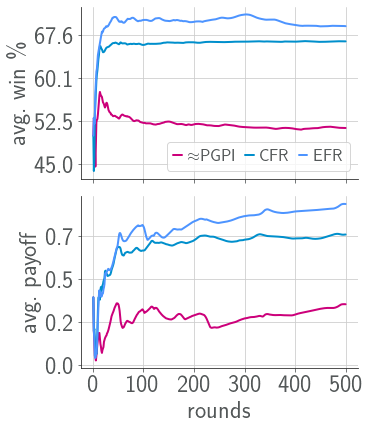

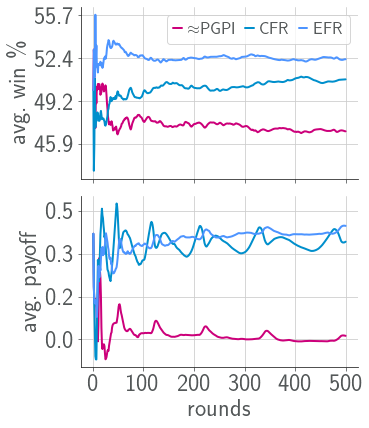

In [10]:
charcoal = '#545859'
mcd_plt.set_plt_params(font_size=24, use_serif=False, color=charcoal)

ylim_by_game = {}
games = ['goofspiel_ascending', 'sheriff']
modes = ['fixed', 'sim']
for mode in modes:
    fig, axes_list = learning_curves_subplots(games, [_algs])
    for i, game_tag in enumerate(sorted(games, key=mcd_tournament.game_sort_key)):
        sharex_and_y_in_row(axes_list[i, :])
        for j, alg_group in enumerate([_algs]):
            ax = axes_list[i, j]
            _df = learning_curve_data(
                data.data.query(
                    learning_curve_query_string.format(
                        game=game_tag,
                        mode=mode,
                        algs=alg_group,
                        col_algs=list(_algs))))
            if is_goofspiel(game_tag):
                _df = goofspiel_learning_curve_config(_df, ax, j)
            elif j == 0:
                ax.set_ylabel(avg_learning_curve_ylabel)
            for alg in _df.columns:
                ax.plot(
                    _df.index.to_numpy() + 1.0,
                    _df[alg],
                    lw=2,
                    alpha=1,
                    label=_alg_label_map[alg],
                    color=alg_color[alg]
                )
            if game_tag in ylim_by_game:
                ax.set_ylim(ylim_by_game[game_tag])
            ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%0.1f'))
            ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))
            ax.grid("on")
            ax.tick_params(colors=charcoal)
        for ax in axes_list[i, :]:
            learning_curves_set_ticks(ax)
    learning_curves_legend(axes_list[0, 0], ncol=3)
    axes_list[0, 0].set_xticklabels([])
    axes_list[-1, 0].set_xlabel('rounds')
    plt.tight_layout(pad=0.1)
    plt.subplots_adjust(wspace=0, hspace=0.1)
    sns.despine()
    plt.savefig(f'results/learning_curves_hr_dt.{mode}.{date}.pdf', transparent=True)